# Bayesian source detection and characterization through Multi-modal nested sampling 

## Introduction

Source extraction is generally performed using a local peak finding approach by separating the background pixels from the pixels belonging to a luminous source. This is followed by measuring the shape and flux parameters of the light distribution. Using the parameters obtained from this a catalogue of objects present in the image is built. This is how the SExtractor tool operates. However this approach fails to extract complete information from the images. The aim of the project is to characterize various astronomical sources by extracting maximum information from the image data and representing it in a functional form. With a prior information of the data, Bayesian inference allows us to fit two dimensional astronomical images into an abstract model.                                                               



A Bayesian approach is taken to the object detection problem. This method detects and characterizes the signal from discrete objects by evaluating the posterior distribution of their parameters given the observed data. To effectively detect multiple modes in the posterior distribution, Multimodal nested sampling is employed. This extends the Nested sampling approach of evaluating Bayesian evidence proposed by John Skilling. 

## Bayesian Inference

Bayesian inference methods provide a consistent approach to the estimation of a set parameters $\theta$ in a model (or hypothesis) $H$ for the data $D$. Bayes’ theorem states that

\begin{align} P_r (\theta|D,H) = \frac {P_r (D|\theta,H) P_r(\theta|H)}{P_r(D|H)}\end{align}

$P_r (\theta|D,H) \equiv P(\theta)$ is the posterior probability distribution of the parameters,
$P_r (D|\theta,H) \equiv L(\theta)$ is the likelihood, 
$P_r (\theta|H) \equiv \pi(\theta)$ is the prior, 
$P_r (D|H) \equiv Z$ is the evidence.

Paramter estimation for the posterior is generally performed using MCMC methods. In contrast to parameter estimation problems, in model selection the evidence takes the central role and is simply the factor required to normalize the posterior over $\theta$:

\begin{align} Z = \int L(\theta) \pi(\theta) d^D \theta \end{align}

where $D$ is the dimensionality of the parameter space. As the average of the likelihood over the prior, the evidence is larger for
a model if more of its parameter space is likely and smaller for a model with large areas in its parameter space having low likelihood
values, even if the likelihood function is very highly peaked. Thus, the evidence automatically implements Occam’s razor: a simpler
theory with compact parameter space will have a larger evidence than a more complicated one, unless the latter is significantly better
at explaining the data. Unfortunately the evaluation of the evidence integral is a challenging numerical task. Standard MCMC methods like thermodynamic integration exist for this type of problem. But thermodynamic integration is prone to have problems and is more demanding computationally. John Skilling proposed a method to tackle this which is the Nested Sampling discussed below.   

# Nested Sampling

Nested sampling (Skilling 2004) is a Monte Carlo technique aimed at efficient evaluation of the Bayesian evidence, but also produces
posterior inferences as a by-product. It exploits the relation between the likelihood and prior volume to transform the multidimensional evidence integral into a one-dimensional integral. The prior volume $X$ is defined by $dX = \pi(\theta) d^D \theta $, so that

\begin{align} X(\lambda) = \int_{L(\theta)>\lambda} \pi(\theta)d^D \theta\end{align}

where the integral extends over the region(s) of parameter space contained within the iso-likelihood contour $L(\theta) = \lambda$. Assuming that $L(X)$ , i.e inverse of the above quantity is a monotonically decreasing function of $X$(Which is trivially satisfied for most posteriors), the evidence integral can then be written as

\begin{align} Z = \int_0^1 L(X) dX \end{align}

Thus if one can evaluate the likelihoods $L_j = L(X_j)$, where $X_j$ is a sequence of decreasing values,

\begin{align} 0 < X_M <...< X_2 < X_1 < X_0 = 1 \end{align}

the evidence can be approximated numerically using standard quadrature methods as weighted sum

\begin{align} Z = \sum_{i=1}^M L_i w_i \end{align}

We will use the simple trapezium rule, for which the weights are given by $ w_i = \frac{1}{2} (X_{i-1} - X_{i+1})$.

The nested sampling algorithm performs the summation as follows.
To begin, the iteration counter is set to i = 0 and N ‘live’
(or ‘active’) samples are drawn from the full prior $\pi(\theta)$ (which
is often simply the uniform distribution over the prior range), so
the initial prior volume is $X_0 = 1$. The samples are then sorted
in order of their likelihood and the smallest (with likelihood $L_0$)
is removed from the live set and replaced by a point drawn from
the prior subject to the constraint that the point has a likelihood
$L > L_0$. The corresponding prior volume contained within this isolikelihood contour will be a random variable given by $X_1 = t_1 X_0$,
where $t_1$ follows the distribution $P_r(t) = N t^{N−1}$ (i.e. the probability distribution for the largest of $N$ samples drawn uniformly
from the interval [0, 1]). At each subsequent iteration $i$, the discarding of the lowest likelihood point $L_i$ in the live set, the drawing of a replacement with $L > L_i$ and the reduction of the corresponding prior volume $X_i = t_i X_{i−1}$ are repeated, until the entire prior volume has been traversed. The algorithm thus travels through nested shells of likelihood as the prior volume is reduced.
The mean and standard deviation of $ln t$, which dominates the
geometrical exploration, are:
\begin{align} E[ln t] = − \frac{1}{N} \end{align}

\begin{align} \sigma[ln t] = \frac {1}{N} \end{align} 

Since each value of $ln t$ is independent, after $i$ iterations the prior
volume will shrink down such that $ln X_i ≈ −(i ± √i)/N$. Thus,
one takes $Xi = exp(−i/N)$. The stopping criterion an be set in several ways. We choose to run the nested sampling loop until the maximum change possible in evidence falls below an user defined value. An option is provided to run the loop until a fixed number of iterations. The posterior samples i.e the lowest likelihood point at each iteration are stored and used later for object detection.

The most challenging task in implementing the nested sampling algorithm is drawing samples from the prior within the hard constraint
$L > L_i$ at each iteration $i$. Employing a naive approach that draws blindly from the prior would result in a steady decrease in
the acceptance rate of new samples with decreasing prior volume (and increasing likelihood). We will investigate this through different strategies using a toy example below.

## Illustration by Example 

First we need to import some modules which will be useful for us.  

In [1]:
from bayes_detect import plot

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 25 days


## In-line plotting with matplotlib

Helps avoid multiple windows for different plots

In [2]:
%matplotlib inline

## Simulated Image for testing

Here we assume sources that we are interested in, are circulary symmetric gaussian objects parametrised in terms of (X,Y) the center of the source, A the amplitude and R the spatial extent of the source. Any point inside the source will obey the following function.

\begin{align} \tau(x,y) = Aexp[- \frac {(x-X)^2+(y-Y)^2}{2R^2}]\end{align}

Therefore we represent an object with four parameters [X,Y,A,R]. The following object data is the one which was used to demnonstrate in the multinest paper by Feroz and Hobson. There are 8 objects in total.  

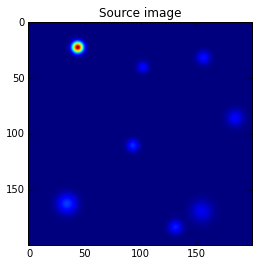

In [3]:
SrcArray = [[43.71, 22.91, 10.54, 3.34],
            [101.62, 40.60, 1.37, 3.40],
            [92.63, 110.56, 1.81, 3.66],
            [183.60, 85.90, 1.23, 5.06],
            [34.12, 162.54, 1.95, 6.02],
            [153.87, 169.18, 1.06, 6.61],
            [155.54, 32.14, 1.46, 4.05],
            [130.56, 183.48, 1.63, 4.11]]

data_map = plot.make_source(src_array = SrcArray,height=200, width=200)

## Adding Noise

We add independent gaussian noise of 2 units RMS to the data map. Now apart from the brightest object all the others are barely visible. The noise added image will be stored in "assets/simulated_images" folder with the name "multinest_toy_noised" for use in the sampler. 

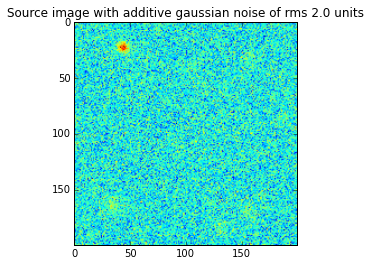

In [4]:
noise = 2.0
data_map = plot.add_gaussian_noise(mean=0,sd=noise,data=data_map)
#plot.write(data_map, "assets/simulated_images/multinest_toy_noised")

## Likelihood formulation

In this case, if the background 'noise' n is a stastically homogeneous Gaussian random field with covariance matrix $N = <n n^t>$, then the likelihood function takes the form

\begin{align} L(a) = \frac { exp [- \frac{1}{2}[D-s(a)]^t N^{-1} [D - s(a)]]}{(2\pi)^{N_{pix} /2}|N|^\frac{1}{2}} \end{align}

In our simple problem the background is just independent pixel noise, so $N = \sigma^2 I$, where $\sigma$ is the noise rms.

## Prior range

The prior on the parameters is assumed to be separable, so that

\begin{align} \pi(source) = \pi(X) \pi(Y) \pi(A) \pi(R) \end{align}

The priors on X and Y are taken to be the uniform distribution U(0, 200), whereas the priors on A and R are taken as the uniform
distributions U(1, 12.5) and U(2, 9) respectively.

In [5]:
prior_array = [[0.0,200.0],[0.0,200.0],[1.0,12.5],[2.0,9.0]]

Now that we formulated our objects, likelihood and prior, We will proceed to the nested sampler. As discussed before, we will investigate three strategies and observe the posterior samples, run-time and accuracy.   

# Uniform Sampler

In Uniform sampling, the search for the point satisfying the constrant $L > L_i$ is performed randomly over the entire prior range. This method keeps on sampling until it finds a desired point and sends it back to the loop. The result for this method are shown below.     

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.06 µs
Iteration: 1  maxZ: 4992.12743019
Iteration: 1000  maxZ: 1390.4977946
Iteration: 2000  maxZ: 834.069315583
Iteration: 3000  maxZ: 607.401109124
Iteration: 4000  maxZ: 490.673303976
Iteration: 5000  maxZ: 442.220993459
elapsed time: 24.3285810947
log evidence: -113023.596905
number of iterations: 5000
likelihood calculations: 13837


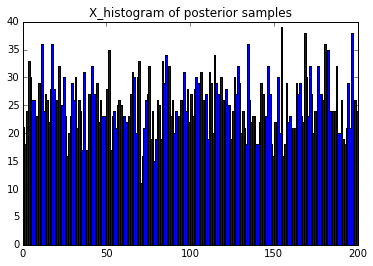

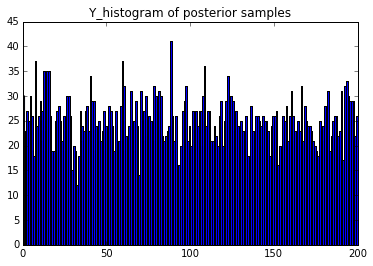

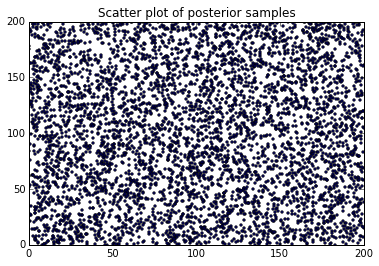

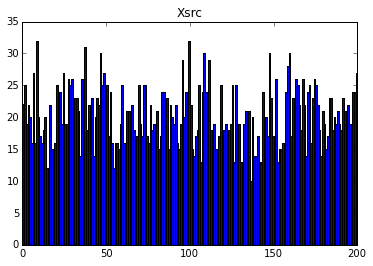

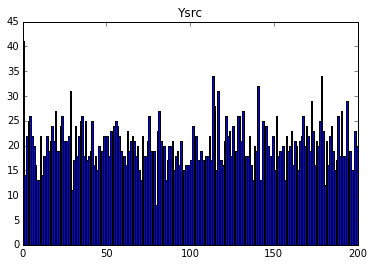

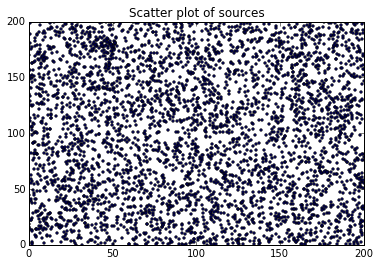

In [6]:
from bayes_detect import sources
sources.run_source_detect(samples = 4000, iterations = 25000, sample_method = "uniform", prior = prior_array, noise_rms = noise, disp = 8.0, mode = "ipython")

If we take a look at the scatter plot of posterior samples. We can make out the objects present in the original image. The histogram plots show where the samples are concentrated at. We can also find that the live points have converged to the brightest source from their scatter plot. The accuracy is not up to the level we desire. The biggest problem with this method is the time taken to complete the sampling procedure. Since it searches uniformly in the entire prior volume which is huge, the runtime of this method is enormous. To tackle this problem, we discuss below an uniform sampler based on the metropolis hastings principle which is a slight improvement over the uniform random sampling.   

## Uniform Metropolis Nested sampling

An alternative method for drawing samples from the prior within the hard constraint $L > L_i$ where $L_i$ is the lowest likelihood value at iteration $i$, is the standardMetropolis algorithm. In this approach, at each iteration, one of the live points, $\theta$, is picked at random and a new trial point,$\theta′$, is generated using a symmetric proposal distribution $Q(\theta′,\theta)$. The trial point $\theta′$ is then accepted with probability

$$ \alpha =
\begin{cases}
1,  & \text{if $\pi(\theta') > \pi(\theta)$ and $L(\theta') > L_i$} \\
\pi(\theta')/\pi(\theta), & \text{if $\pi(\theta') \le \pi(\theta)$ and $L(\theta') > L_i$}  \\
0, & \text{otherwise}  \\
\end{cases}$$

A symmetric Gaussian distribution is often used as the proposal distribution. The dispersion $\sigma$ of this Gaussian should be sufficiently large compared to the size of the region satisfying $L > L_i$ that the chain is reasonably mobile, but without being so large that the likelihood constraint stops nearly all proposed moves. Since an independent sample is required, $n_step$ steps are taken by the Metropolis algorithm so that the chain diffuses far away from the starting position \theta and the memory of it is lost. In principle, one could calculate convergence statistics to determine at which point the chain is sampling from the target distribution. Sivia et al. (2006) propose, however, that one should instead simply take $n_step ≈ 20$ steps
in all cases. The appropriate value of $\sigma$  tends to diminish as the
nested algorithm moves towards higher likelihood regions and decreasing
prior mass. Hence, the value of $\sigma$ is updated at the end of
each nested sampling iteration, so that the acceptance rate is around
50%, as follows:

$$ \sigma =
\begin{cases}
\sigma e^{1/N_a}, & \text{ if $N_a > N_r$} \\
\sigma e^{-1/N_r}, & \text{ if $N_a \le N_r$} \\
\end{cases}$$

where $N_a$ and $N_r$ are the numbers of accepted and rejected samples
in the latest Metropolis sampling phase.

CPU times: user 4 µs, sys: 3 µs, total: 7 µs
Wall time: 8.82 µs
Iteration: 1  maxZ: 5312.47184916
Iteration: 1000  maxZ: 1347.43433555
Iteration: 2000  maxZ: 927.732150774
Iteration: 3000  maxZ: 696.834171518
Iteration: 4000  maxZ: 583.010945459
Iteration: 5000  maxZ: 512.109118123
elapsed time: 176.123432159
log evidence: -113030.526687
number of iterations: 5000
likelihood calculations: 108979


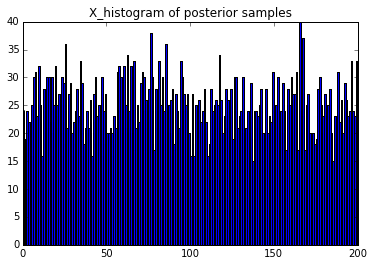

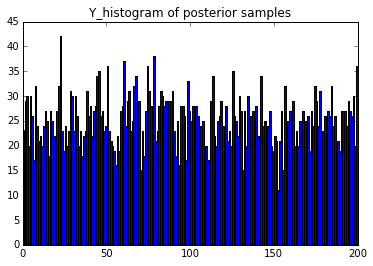

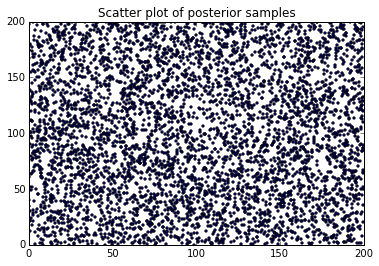

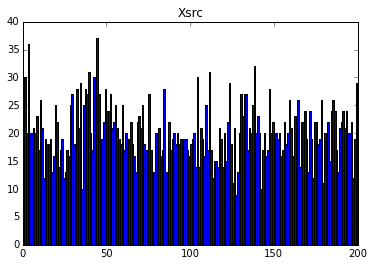

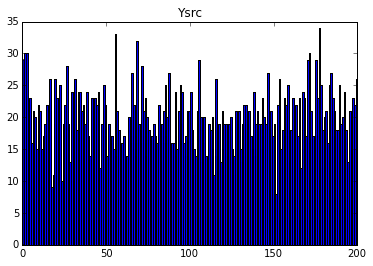

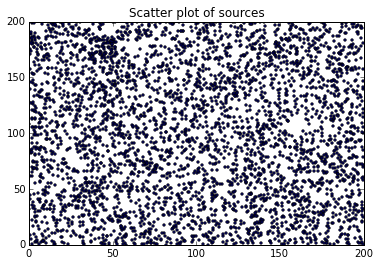

In [7]:
%time
from bayes_detect import sources
sources.run_source_detect(samples = 4000, iterations = 25000, sample_method = "metropolis", prior = prior_array, noise_rms = noise, disp = 10.0, mode = "ipython")

The posterior samples appear concentrated in the areas where objects are present. The live points are converged to the brightest source. The accuracy is not still up to the level we desire. But there is a significant improvement in runtime. This method mainly depends on the number of live points. To effectively sample the prior space we should generally take large number of live points. But we still have to solve the accuracy problem, so we are going to try an improvement over random sampling below.  

# Clustered ellipsoidal sampler

Application of Ellipsoidal sampling seems a better idea since we are dealing with detection of discrete circularly symmetric objects. At each iteration of the nested sampling procedure, the entire live point set is clustered based on their proximity. Each cluster is enclosed by its minimum volume bounding ellipsoid. The figure below shows how a minimum volume bounding ellipsoid looks.   

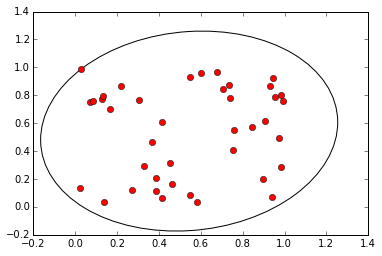

In [8]:
import numpy as np
X = np.random.rand(40,2)
plot.plot_ellipse(X)

As we can see above a minimum volume bounding ellipsoid encloses all the points given with minimum possible volume. All the clusters are enclosed in this way and enlarged by a factor to not loose the missing likelihood levels. The clustered ellipsoidal set will look like this   

In [9]:
"""
from Scripts import clust_ellip
import numpy as np
X = np.random.rand(150,2)
clust_ellip.show_minimum_bounding_ellipsoids(Xr=X)
"""

'\nfrom Scripts import clust_ellip\nimport numpy as np\nX = np.random.rand(150,2)\nclust_ellip.show_minimum_bounding_ellipsoids(Xr=X)\n'

In [10]:
#clust_ellip.show_minimum_bounding_ellipsoids(Xr=X, with_sampled = True)

From the ellipsoid set we will choose an ellipsoid at random and sample from it to find a desired point. As the method proceeds the cluster centres will come closer to the object centres.  

CPU times: user 4 µs, sys: 3 µs, total: 7 µs
Wall time: 10 µs
Iteration: 1  maxZ: 4983.18522869
Iteration: 1000  maxZ: 620.265158904
Iteration: 2000  maxZ: 387.357912507
Iteration: 3000  maxZ: 360.984199403
Iteration: 4000  maxZ: 344.53648303
elapsed time: 1263.30455184
log evidence: -112893.054342
number of iterations: 4000
likelihood calculations: 35211


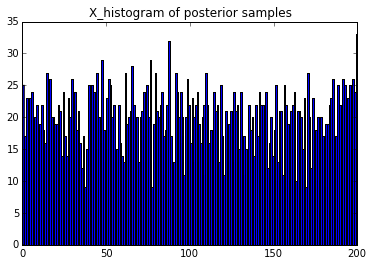

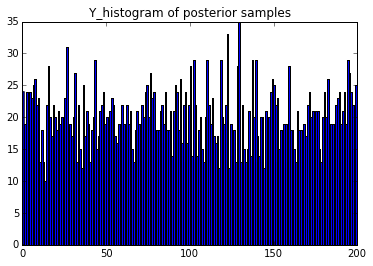

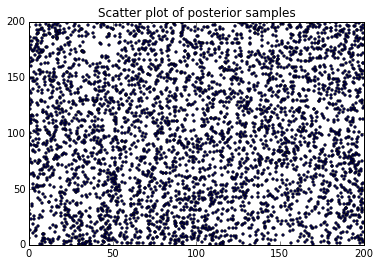

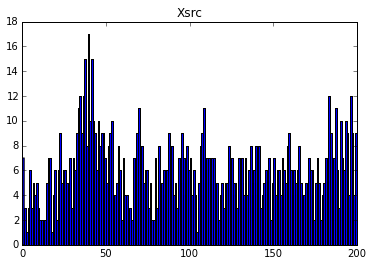

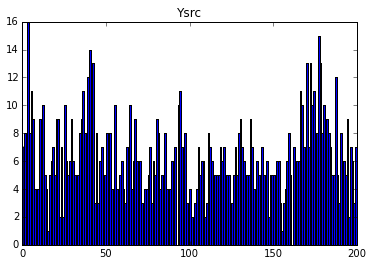

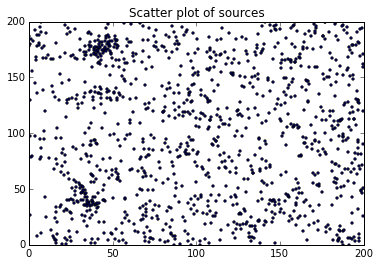

In [11]:
%time
from bayes_detect import sources
sources.run_source_detect(samples = 1200, iterations = 14000, sample_method = "clustered_ellipsoidal", prior = prior_array, noise_rms = noise, disp = 8.0, mode = "ipython")

Posterior samples have a better accuracy and are clearly visible as the objects. The histogram plots show more precision in approximating the object existence. All the live points appear to be converged to the brightest source. The clustered ellipsoidal sampler provides better samples but still take more time due to the clustering method used (DBSCAN).

# Improved Clustered ellipsoidal sampler

The above ellipsoidal method gives better samples but takes a lot of time to give a usable posterior set. We have to cluster all points at each iteration using DBSCAN method and this takes majority of runtime. If we observe closely, clustering may not be needed at every iteration since replacement of one point out of 1200 live points doesn't make much difference. What we can do instead is cluster every 30 or 50 iterations, remember the ellipsoid set and sample from them for the next 29 or 59 iterations respectively. To run the nested sampler in this method provide "sample_method" parameter as "new". The results are as below :   

Iteration: 1  maxZ: 4567.16107983
Iteration: 1000  maxZ: 482.717675309
Iteration: 2000  maxZ: 297.259204782
Iteration: 3000  maxZ: 247.981599426
Iteration: 4000  maxZ: 393.933582985
elapsed time: 77.4032428265
log evidence: -112893.113552
number of iterations: 4000
likelihood calculations: 34818


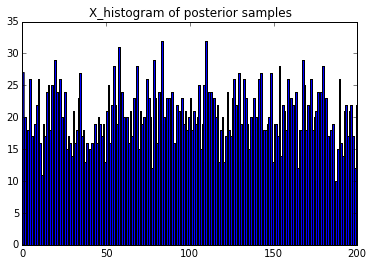

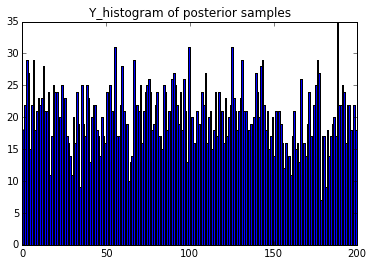

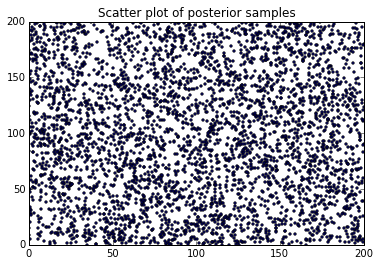

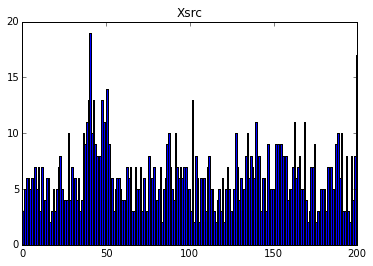

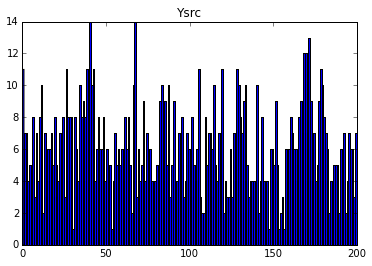

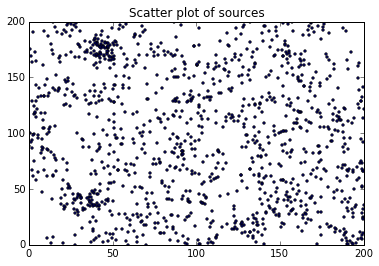

In [12]:
#time
from bayes_detect import sources
sources.run_source_detect(samples = 1200, iterations = 14000, sample_method = "new", prior = prior_array, noise_rms = noise, disp = 8.0, mode = "ipython")

As you can see above, the runtime is improved. We get samples with same accuracy as before. However there is still a scope for lot of improvement. Since we are uniformly sampling we can take advantage of multicore parallel processing and apply it to the sampling phase to gain some speed improvement. This task is still in progress. I will add the option to this include it in the coming days. 

## TO-DO

1. Until now we are able to get good samples. But we have to find the object locations by evaluating the local evidence for each cluster. We need to identify the same cluster in every iteration and update its local evidence. For this we need a clustering procedure which can consistenly identify the samples belonging to the same cluster.

2. We have to improve the speed by many levels so that the method works for images of larger size. 

##  References

1. Multinest paper by Feroz and Hobson 2008.
http://arxiv.org/abs/0704.3704
2. Shaw R., Bridges M., Hobson M.P., 2007, MNRAS, in press (astro-ph/0701867)
http://arxiv.org/abs/astro-ph/0701867
3. http://www.inference.phy.cam.ac.uk/bayesys/
4. Nested sampling paper by John Skilling. 
http://www.inference.phy.cam.ac.uk/bayesys/nest.pdf